## Graph and Table Detection

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import os
#import cv2
import numpy as np
from PIL import Image

In [2]:

class AudiogramDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.imgs = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        # For training, you'll need to provide bounding box annotations
        img_path = self.imgs[idx]
        image = Image.open(img_path).convert("RGB")
        
        # Example annotation format - you'll need to replace with actual annotations
        # Each audiogram would have bbox coordinates for graph and table
        # Format: [x_min, y_min, x_max, y_max, class_label]
        boxes = torch.tensor([[50, 50, 300, 400, 0], [350, 50, 500, 200, 1]], dtype=torch.float32)
        
        target = {}
        target["boxes"] = boxes[:, :4]
        target["labels"] = boxes[:, 4].long()
        
        if self.transform:
            image = self.transform(image)
            
        return image, target

# Data transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Create the dataset
dataset = AudiogramDataset(
    img_dir='graph_and_table_detection_train',
    transform=transform
)

# Create data loader
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the model for our specific classes (graph and table)
num_classes = 3  # Background, Graph, Table
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Training setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        i += 1
        if i % 10 == 0:
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {losses.item()}")

# Save the model
torch.save(model.state_dict(), "audiogram_graph_detector.pth")

C:\Users\cadem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\cadem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 10, Loss: 0.0825258195400238
Epoch: 1, Batch: 10, Loss: 0.14486227929592133
Epoch: 2, Batch: 10, Loss: 0.15715241432189941
Epoch: 3, Batch: 10, Loss: 0.0797095000743866
Epoch: 4, Batch: 10, Loss: 0.07068836688995361
Epoch: 5, Batch: 10, Loss: 0.04298598691821098
Epoch: 6, Batch: 10, Loss: 0.0348522923886776
Epoch: 7, Batch: 10, Loss: 0.02960074506700039
Epoch: 8, Batch: 10, Loss: 0.024605605751276016
Epoch: 9, Batch: 10, Loss: 0.014221623539924622


## Symbol Detection

In [6]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
class SymbolDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []
        
        # Define the classes
        self.classes = ['Air Conduction', 'Bone Conduction']
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        print(f"Looking for images in: {root_dir}")
        # List all files in the root directory
        for img_name in os.listdir(root_dir):
            img_path = os.path.join(root_dir, img_name)
            if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Determine the class based on filename
                if 'air_conduction' in img_name.lower():
                    class_name = 'Air Conduction'
                    class_idx = self.class_to_idx[class_name]
                    self.samples.append((img_path, class_idx))
                    print(f"Added image: {img_path} as {class_name}")
                elif 'bone_conduction' in img_name.lower():
                    class_name = 'Bone Conduction'
                    class_idx = self.class_to_idx[class_name]
                    self.samples.append((img_path, class_idx))
                    print(f"Added image: {img_path} as {class_name}")
                else:
                    print(f"Skipping image with unknown class: {img_path}")
        
        print(f"Total samples found: {len(self.samples)}")
        if len(self.samples) == 0:
            raise ValueError(f"No valid image files found in {root_dir}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
                
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            # Return a placeholder in case of error
            if self.transform:
                return torch.zeros((3, 64, 64)), label
            else:
                return Image.new('RGB', (64, 64)), label
            
# Data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with verbose output
try:
    train_dataset = SymbolDataset(root_dir='symbol_detection_train', transform=transform)
    print(f"Successfully created dataset with {len(train_dataset)} samples")
    train_loader = DataLoader(train_dataset, batch_size=min(32, len(train_dataset)), shuffle=True)
except Exception as e:
    print(f"Error creating dataset: {str(e)}")
    # Print directory contents for debugging
    print("Contents of symbol_detection_train:")
    for root, dirs, files in os.walk('symbol_detection_train'):
        print(f"Directory: {root}")
        print(f"  Subdirectories: {dirs}")
        print(f"  Files: {files}")
        
# Define the model
class SymbolClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SymbolClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Set up the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SymbolClassifier(num_classes=len(train_dataset.classes))
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

# Save the model
torch.save(model.state_dict(), "audiogram_symbol_classifier.pth")



Looking for images in: symbol_detection_train
Added image: symbol_detection_train\air_conduction_symbol1.PNG as Air Conduction
Added image: symbol_detection_train\air_conduction_symbol2.PNG as Air Conduction
Added image: symbol_detection_train\Bone_conduction_symbol1.PNG as Bone Conduction
Added image: symbol_detection_train\Bone_conduction_symbol2.PNG as Bone Conduction
Added image: symbol_detection_train\Bone_conduction_symbol3.PNG as Bone Conduction
Added image: symbol_detection_train\Bone_conduction_symbol4.PNG as Bone Conduction
Total samples found: 6
Successfully created dataset with 6 samples
Epoch 1/10, Loss: 0.6885644793510437
Epoch 2/10, Loss: 0.601589024066925
Epoch 3/10, Loss: 0.6603747010231018
Epoch 4/10, Loss: 0.6005908846855164
Epoch 5/10, Loss: 0.5782956480979919
Epoch 6/10, Loss: 0.5709977746009827
Epoch 7/10, Loss: 0.5515835285186768
Epoch 8/10, Loss: 0.4311070740222931
Epoch 9/10, Loss: 0.5189221501350403
Epoch 10/10, Loss: 0.5883750319480896


In [9]:
os.path.abspath('symbol_detection_train')

'c:\\Users\\cadem\\OneDrive\\Documents\\COLLEGE\\SENIOR\\Spring 2025\\Deep Learning in AI\\Project\\Code\\AI CODE TESTING\\symbol_detection_train'

## Hearing Loss Classification

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

class HearingLossDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []
        
        # Define the classes based on your directory structure
        self.classes = ['No Hearing Loss', 'Conductive Hearing Loss', 'Sensorineural Hearing Loss']
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        print(f"Looking for images in: {root_dir}")
        
        # Map folder names to class names
        folder_to_class = {
            'no_hearing_loss_train': 'No Hearing Loss',
            'conductive_hearing_loss_train': 'Conductive Hearing Loss', 
            'sensorineural_hearing_loss_train': 'Sensorineural Hearing Loss'
        }
        
        # Scan through the training directories directly
        for folder_name, class_name in folder_to_class.items():
            folder_path = os.path.join(root_dir, folder_name)
            if os.path.exists(folder_path) and os.path.isdir(folder_path):
                print(f"Scanning directory: {folder_path}")
                for img_name in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, img_name)
                    if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        class_idx = self.class_to_idx[class_name]
                        self.samples.append((img_path, class_idx))
                        print(f"Added image: {img_path} as {class_name}")
            else:
                print(f"Warning: Directory {folder_path} not found")
        
        print(f"Total samples found: {len(self.samples)}")
        if len(self.samples) == 0:
            raise ValueError(f"No valid image files found in the directories under {root_dir}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
                
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            # Return a placeholder in case of error
            if self.transform:
                return torch.zeros((3, 224, 224)), label
            else:
                return Image.new('RGB', (224, 224)), label

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset and print debugging information
try:
    dataset = HearingLossDataset(root_dir='hearing_loss_classification_train', transform=transform)
    print(f"Successfully created dataset with {len(dataset)} samples")
    data_loader = DataLoader(dataset, batch_size=min(16, len(dataset)), shuffle=True)
except Exception as e:
    print(f"Error creating dataset: {str(e)}")
    # Print directory contents for debugging
    print("Contents of directory:")
    for root, dirs, files in os.walk('hearing_loss_classification_train'):
        print(f"Directory: {root}")
        print(f"  Subdirectories: {dirs}")
        print(f"  Files: {files}")

# Define the model - using a pre-trained ResNet for transfer learning
class HearingLossClassifier(nn.Module):
    def __init__(self, num_classes):
        super(HearingLossClassifier, self).__init__()
        self.backbone = torchvision.models.resnet50(pretrained=True)
        
        # Freeze earlier layers
        for param in list(self.backbone.parameters())[:-20]:
            param.requires_grad = False
            
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# Set up the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HearingLossClassifier(num_classes=len(dataset.classes))
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(data_loader)}, Accuracy: {100 * correct / total}%")

# Save the model
torch.save(model.state_dict(), "hearing_loss_classifier.pth")

Looking for images in: hearing_loss_classification_train
Scanning directory: hearing_loss_classification_train\no_hearing_loss_train
Added image: hearing_loss_classification_train\no_hearing_loss_train\N1 Left.jpg as No Hearing Loss
Added image: hearing_loss_classification_train\no_hearing_loss_train\N11 Left.jpg as No Hearing Loss
Added image: hearing_loss_classification_train\no_hearing_loss_train\N120 Right.jpg as No Hearing Loss
Added image: hearing_loss_classification_train\no_hearing_loss_train\N136 Right.jpg as No Hearing Loss
Added image: hearing_loss_classification_train\no_hearing_loss_train\N137 Right.jpg as No Hearing Loss
Added image: hearing_loss_classification_train\no_hearing_loss_train\N14 Left.jpg as No Hearing Loss
Added image: hearing_loss_classification_train\no_hearing_loss_train\N15 Left.jpg as No Hearing Loss
Added image: hearing_loss_classification_train\no_hearing_loss_train\N170 Right.jpg as No Hearing Loss
Added image: hearing_loss_classification_train\no_he

## Combonation of all Models

Using device: cuda
Loading graph detector model...


C:\Users\cadem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\cadem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\cadem\AppData\Local\Temp\ipykernel_16076\1654992366.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary 

Graph detector loaded successfully
Loading symbol classifier model...
Symbol classifier loaded successfully
Loading hearing loss classifier model...


C:\Users\cadem\AppData\Local\Temp\ipykernel_16076\1654992366.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.hearing_loss_classifier.load_state_dict(torch.load(he

Hearing loss classifier loaded successfully
Analyzing audiogram: C:\Users\cadem\OneDrive\Documents\COLLEGE\SENIOR\Spring 2025\Deep Learning in AI\Project\Code\Left_Ear_Charts\T122 Left.jpg
Step 1: Detecting graph and table regions...
Found graph region with confidence 0.99
Step 2: Detecting symbols...
Detected 0 symbols
Step 3: Running hearing loss classifier...
Classifier result: Sensorineural Hearing Loss

--- Audiogram Analysis Results ---
Hearing Loss Type: Sensorineural Hearing Loss

Confidence Scores:
  - No Hearing Loss: 12.18%
  - Conductive Hearing Loss: 1.92%
  - Sensorineural Hearing Loss: 85.90%

Detected 0 symbols
Saved visualization to T122 Left_analysis.png


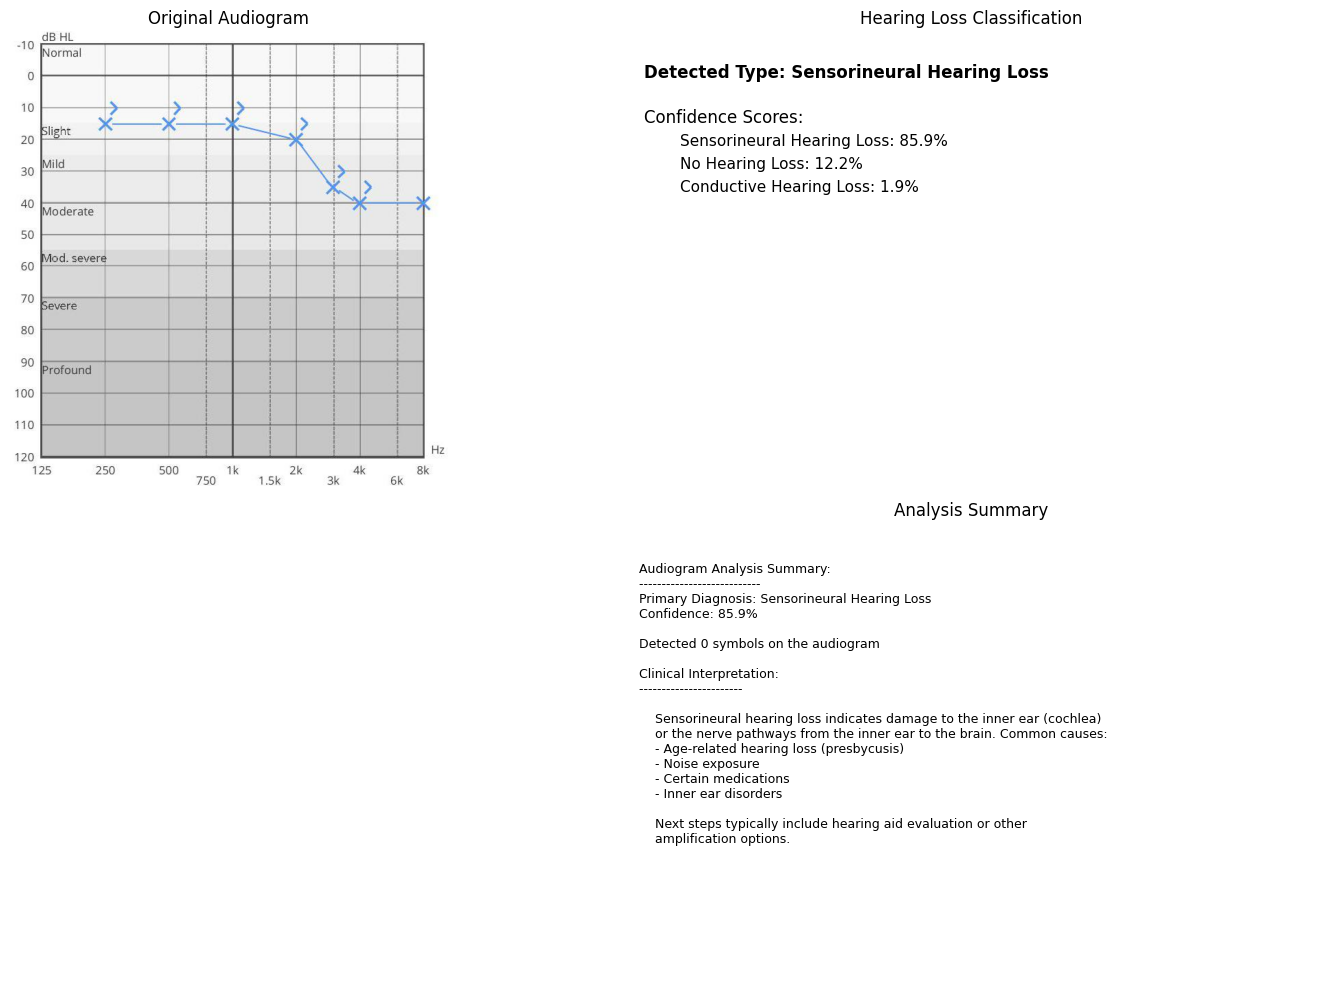

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as transforms
from PIL import Image
#import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset

from PIL import Image
import os


# Define your model architectures (same as during training)
class SymbolClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SymbolClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class HearingLossClassifier(nn.Module):
    def __init__(self, num_classes):
        super(HearingLossClassifier, self).__init__()
        self.backbone = torchvision.models.resnet50(pretrained=True)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

class AudiogramAnalyzer:
    def __init__(self, 
                 graph_detector_path="audiogram_graph_detector.pth",
                 symbol_classifier_path="audiogram_symbol_classifier.pth",
                 hearing_loss_classifier_path="hearing_loss_classifier.pth"):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Load Graph and Table Detector
        print("Loading graph detector model...")
        self.graph_detector = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=3)
        if os.path.exists(graph_detector_path):
            self.graph_detector.load_state_dict(torch.load(graph_detector_path, map_location=self.device))
            self.graph_detector.to(self.device)
            self.graph_detector.eval()
            print("Graph detector loaded successfully")
        else:
            print(f"Warning: Graph detector model not found at {graph_detector_path}")
            print("Graph and table detection will be skipped")
            self.graph_detector = None

        # Load Symbol Classifier
        print("Loading symbol classifier model...")
        self.symbol_classifier = SymbolClassifier(num_classes=2)  # air, bone
        if os.path.exists(symbol_classifier_path):
            self.symbol_classifier.load_state_dict(torch.load(symbol_classifier_path, map_location=self.device))
            self.symbol_classifier.to(self.device)
            self.symbol_classifier.eval()
            print("Symbol classifier loaded successfully")
        else:
            print(f"Warning: Symbol classifier model not found at {symbol_classifier_path}")
            print("Symbol detection will be skipped")
            self.symbol_classifier = None
        
        # Load Hearing Loss Classifier
        print("Loading hearing loss classifier model...")
        self.hearing_loss_classifier = HearingLossClassifier(num_classes=3)  # normal, conductive, sensorineural
        if os.path.exists(hearing_loss_classifier_path):
            self.hearing_loss_classifier.load_state_dict(torch.load(hearing_loss_classifier_path, map_location=self.device))
            self.hearing_loss_classifier.to(self.device)
            self.hearing_loss_classifier.eval()
            print("Hearing loss classifier loaded successfully")
        else:
            print(f"Warning: Hearing loss classifier model not found at {hearing_loss_classifier_path}")
            print("Hearing loss classification will be skipped")
            self.hearing_loss_classifier = None
        
        # Define transformations
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        self.symbol_transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.hearing_loss_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Define class labels
        self.symbol_classes = ['Air Conduction', 'Bone Conduction']
        self.hearing_loss_classes = ['No Hearing Loss', 'Conductive Hearing Loss', 'Sensorineural Hearing Loss']
       
def preprocess_image(self, image_path):
        """Load and preprocess the audiogram image"""
        try:
            image = Image.open(image_path).convert("RGB")
            return image
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None
    
        def detect_graph_and_table(self, image):
        """Detect audiogram graph and table regions"""
        if self.graph_detector is None:
            print("Graph detector not loaded, using full image")
            return image, None
        
        with torch.no_grad():
            img_tensor = self.transform(image).unsqueeze(0).to(self.device)
            predictions = self.graph_detector(img_tensor)
            
        boxes = predictions[0]['boxes'].cpu().numpy().astype(np.int32)
        scores = predictions[0]['scores'].cpu().numpy()
        labels = predictions[0]['labels'].cpu().numpy()
        
        # Filter detections by confidence threshold
        confident_detections = scores > 0.5
        
        graph_region = None
        table_region = None
        
        # Find the graph and table regions
        for box, label, score in zip(boxes[confident_detections], 
                                     labels[confident_detections], 
                                     scores[confident_detections]):
            if label == 1:  # Graph label
                print(f"Found graph region with confidence {score:.2f}")
                x1, y1, x2, y2 = max(0, box[0]), max(0, box[1]), min(image.width, box[2]), min(image.height, box[3])
                graph_region = image.crop((x1, y1, x2, y2))
            elif label == 2:  # Table label
                print(f"Found table region with confidence {score:.2f}")
                x1, y1, x2, y2 = max(0, box[0]), max(0, box[1]), min(image.width, box[2]), min(image.height, box[3])
                table_region = image.crop((x1, y1, x2, y2))
        
        if graph_region is None:
            print("No graph region detected, using full image")
            graph_region = image
            
        return graph_region, table_region
    
    def detect_symbols(self, graph_region):
        """Detect and classify audiogram symbols"""
        if self.symbol_classifier is None:
            print("Symbol classifier not loaded, skipping symbol detection")
            return []
        
        # In a real implementation, you'd use an object detection model first
        # to identify the locations of symbols, then classify each detected symbol
        
        # For now, we'll create a grid over the graph region and check each cell for symbols
        width, height = graph_region.size
        grid_size = 20  # pixels
        symbols = []
        
        # Simulate symbol detection by sliding a window across the image
        for y in range(0, height - grid_size, grid_size):
            for x in range(0, width - grid_size, grid_size):
                # Extract a small region that might contain a symbol
                window = graph_region.crop((x, y, x + grid_size, y + grid_size))
                
                # Classify the window
                with torch.no_grad():
                    window_tensor = self.symbol_transform(window).unsqueeze(0).to(self.device)
                    outputs = self.symbol_classifier(window_tensor)
                    _, predicted = torch.max(outputs, 1)
                    confidence = torch.nn.functional.softmax(outputs, dim=1)[0][predicted.item()].item()
                
                # If confidence is high enough, consider it a valid symbol
                if confidence > 0.7:  # Threshold can be adjusted
                    symbol_class = self.symbol_classes[predicted.item()]
                    # Estimate frequency and dB from position
                    # In a real system, you'd need to calibrate this based on the audiogram's axes
                    freq_estimate = (x / width) * 8000  # Example: map x to 0-8000 Hz
                    db_estimate = 120 - (y / height) * 120  # Example: map y to 0-120 dB
                    
                    symbols.append({
                        'type': symbol_class,
                        'position': (x, y),
                        'frequency': freq_estimate,
                        'decibel': db_estimate,
                        'confidence': confidence
                    })
        
        return symbols
    
    def analyze_hearing_loss(self, image):
        """Classify the type of hearing loss"""
        if self.hearing_loss_classifier is None:
            print("Hearing loss classifier not loaded, skipping classification")
            return "Unknown", {}
        
        with torch.no_grad():
            # Preprocess the image for the hearing loss classifier
            img_tensor = self.hearing_loss_transform(image).unsqueeze(0).to(self.device)
            
            # Get the classifier prediction
            outputs = self.hearing_loss_classifier(img_tensor)
            _, predicted = torch.max(outputs, 1)
            
            predicted_class = self.hearing_loss_classes[predicted.item()]
            
            # Get confidence scores for all classes
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[0].cpu().numpy()
            
            class_probabilities = {cls: float(prob) for cls, prob in zip(self.hearing_loss_classes, probabilities)}
            
        return predicted_class, class_probabilities
    
    

    def analyze_from_symbols(self, symbols):
        """Determine hearing loss type from detected symbols"""
        # This is a simplified rule-based approach
        # In a real system, you'd need more sophisticated rules based on clinical criteria
        
        if not symbols:
            return "Cannot determine - insufficient symbol data"
        
        # Extract air and bone conduction symbols
        air_symbols = [s for s in symbols if s['type'] == 'Air Conduction']
        bone_symbols = [s for s in symbols if s['type'] == 'Bone Conduction']
        
        if not air_symbols or not bone_symbols:
            return "Cannot determine - need both air and bone conduction data"
        
        # Calculate average air-bone gap
        air_bone_gaps = []
        for air in air_symbols:
            for bone in bone_symbols:
                # If symbols are at roughly the same frequency
                if abs(air['frequency'] - bone['frequency']) < 200:  # Tolerance level
                    gap = air['decibel'] - bone['decibel']
                    air_bone_gaps.append(gap)
        
        if not air_bone_gaps:
            return "Cannot determine - no matching frequency points"
        
        avg_gap = sum(air_bone_gaps) / len(air_bone_gaps)
        
        # Clinical rule: gap > 10 dB indicates conductive component
        if avg_gap > 10:
            return "Conductive Hearing Loss (from symbol analysis)"
        else:
            return "Sensorineural Hearing Loss (from symbol analysis)"

    
    def analyze_audiogram(self, image_path):
        """Complete audiogram analysis pipeline"""
        print(f"Analyzing audiogram: {image_path}")
        
        # Load and preprocess the image
        original_image = self.preprocess_image(image_path)
        if original_image is None:
            return {"error": "Failed to load image"}
        
        # Step 1: Detect graph and table regions
        print("Step 1: Detecting graph and table regions...")
        graph_region, table_region = self.detect_graph_and_table(original_image)
        
        # Step 2: Detect symbols in the graph
        print("Step 2: Detecting symbols...")
        symbols = self.detect_symbols(graph_region)
        print(f"Detected {len(symbols)} symbols")
        
        # Get a preliminary analysis from symbol positions (rule-based)
        symbol_based_analysis = None
        if len(symbols) > 3:  # Only if we have enough symbols
            symbol_based_analysis = self.analyze_from_symbols(symbols)
            print(f"Symbol-based analysis result: {symbol_based_analysis}")
        
        # Step 3: Analyze hearing loss type using the classifier
        print("Step 3: Running hearing loss classifier...")
        hearing_loss_type, probabilities = self.analyze_hearing_loss(original_image)
        print(f"Classifier result: {hearing_loss_type}")
        
        # Create analysis report
        report = {
            "hearing_loss_type": hearing_loss_type,
            "confidence_scores": probabilities,
            "symbols_detected": len(symbols),
            "symbol_details": symbols[:5],  # First few symbols for reference
            "symbol_based_analysis": symbol_based_analysis
        }
        
        return report
    
    def visualize_results(self, image_path, report):
        """Visualize the audiogram analysis results"""
        image = Image.open(image_path)
        image_array = np.array(image)
        
        plt.figure(figsize=(15, 10))
        
        # Display original image
        plt.subplot(2, 2, 1)
        plt.imshow(image)
        plt.title("Original Audiogram")
        plt.axis("off")
        
        # Display hearing loss classification results
        plt.subplot(2, 2, 2)
        plt.axis("off")
        plt.title("Hearing Loss Classification")
        
        # Display classification results
        y_pos = 0.9
        plt.text(0.05, y_pos, f"Detected Type: {report['hearing_loss_type']}", fontsize=12, fontweight='bold')
        y_pos -= 0.1
        
        plt.text(0.05, y_pos, "Confidence Scores:", fontsize=12)
        y_pos -= 0.05
        
        # Sort classes by confidence
        sorted_classes = sorted(report['confidence_scores'].items(), key=lambda x: x[1], reverse=True)
        for cls, prob in sorted_classes:
            plt.text(0.1, y_pos, f"{cls}: {prob:.1%}", fontsize=11)
            y_pos -= 0.05
        
        # If we have a symbol-based analysis
        if report.get('symbol_based_analysis'):
            y_pos -= 0.05
            plt.text(0.05, y_pos, f"Symbol Analysis: {report['symbol_based_analysis']}", fontsize=12)
        
        # Display detected symbols on the image
        if report['symbols_detected'] > 0 and 'symbol_details' in report:
            plt.subplot(2, 2, 3)
            plt.imshow(image)
            plt.title(f"Detected Symbols ({report['symbols_detected']} total)")
            
            # Draw symbol positions if available
            for symbol in report['symbol_details']:
                if 'position' in symbol:
                    x, y = symbol['position']
                    plt.plot(x, y, 'ro', markersize=10)
                    plt.text(x+5, y+5, symbol['type'], fontsize=8, color='white', 
                             bbox=dict(facecolor='red', alpha=0.5))
            
            plt.axis("off")
        
        # Display a summary
        plt.subplot(2, 2, 4)
        plt.axis("off")
        plt.title("Analysis Summary")
        
        summary_text = f"""
        Audiogram Analysis Summary:
        ---------------------------
        Primary Diagnosis: {report['hearing_loss_type']}
        Confidence: {report['confidence_scores'].get(report['hearing_loss_type'], 0):.1%}
        
        Detected {report['symbols_detected']} symbols on the audiogram
        
        Clinical Interpretation:
        -----------------------
        """
        
        # Add some clinical interpretation based on the hearing loss type
        if "Conductive" in report['hearing_loss_type']:
            summary_text += """
            Conductive hearing loss indicates problems in the outer or middle ear
            that prevent sound from being conducted to the inner ear. Common causes:
            - Ear wax blockage
            - Middle ear fluid
            - Otosclerosis
            - Perforated eardrum
            
            Next steps may include medical referral, as conductive hearing loss
            often has medical or surgical treatment options.
            """
        elif "Sensorineural" in report['hearing_loss_type']:
            summary_text += """
            Sensorineural hearing loss indicates damage to the inner ear (cochlea)
            or the nerve pathways from the inner ear to the brain. Common causes:
            - Age-related hearing loss (presbycusis)
            - Noise exposure
            - Certain medications
            - Inner ear disorders
            
            Next steps typically include hearing aid evaluation or other
            amplification options.
            """
        else:
            summary_text += """
            The audiogram results require further evaluation to determine
            appropriate intervention strategies.
            """
        
        plt.text(0, 0.95, summary_text, fontsize=9, va='top', ha='left', wrap=True)
        
        plt.tight_layout()
        
        # Save the visualization
        output_filename = os.path.splitext(os.path.basename(image_path))[0] + "_analysis.png"
        plt.savefig(output_filename)
        print(f"Saved visualization to {output_filename}")
        
        # Show the plot
        plt.show()
        
        return output_filename

# Example usage
def analyze_audiogram_sample(audiogram_path):
    analyzer = AudiogramAnalyzer(
        graph_detector_path="audiogram_graph_detector.pth",
        symbol_classifier_path="audiogram_symbol_classifier.pth",
        hearing_loss_classifier_path="hearing_loss_classifier.pth"
    )
    
    # Analyze the audiogram
    report = analyzer.analyze_audiogram(audiogram_path)
    
    # Print results
    print("\n--- Audiogram Analysis Results ---")
    print(f"Hearing Loss Type: {report['hearing_loss_type']}")
    print("\nConfidence Scores:")
    for cls, prob in report['confidence_scores'].items():
        print(f"  - {cls}: {prob:.2%}")
    
    print(f"\nDetected {report['symbols_detected']} symbols")
    
    # Visualize results
    analyzer.visualize_results(audiogram_path, report)
    
    return report



# Use this function to analyze a single audiogram
if __name__ == "__main__":
    # Replace with the path to your test audiogram
    test_audiogram = "C:\\Users\\cadem\\OneDrive\\Documents\\COLLEGE\\SENIOR\\Spring 2025\\Deep Learning in AI\\Project\\Code\\Left_Ear_Charts\\T122 Left.jpg"
    analyze_audiogram_sample(test_audiogram)

In [10]:
import cv2

ModuleNotFoundError: No module named 'cv2'